<a href="https://colab.research.google.com/github/michalis0/Business-Intelligence-and-Analytics/blob/master/labs/09%20-%20Regression%202/Walkthrough/walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Walkthrough : Regression 2

This week we continue working on regression. Diving into more specific methods, we will show you how to choose the number of parameters, cross validation and 1-hot/label encoding.

# REGRESSION WITH CATEGORICAL VARIABLES

In [ ]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import statistics

## Load the dataset

The Dataset we will be working on was extracted and modified from [Kaggle](https://www.kaggle.com/mohansacharya/graduate-admissions). It gives us various information concerning students and their chances of admission.


In [2]:
# Load the dataset
url = 'https://media.githubusercontent.com/media/michalis0/Business-Intelligence-and-Analytics/master/data/Admissions_prediction.csv'
GAD = pd.read_csv(url, sep = ";", index_col= 'Serial No.').drop_duplicates() # Graduate Admissions Data

display(GAD.head())
print(GAD.dtypes)
print("Data matrix shape: ", GAD.shape)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,GOOD,4.5,4.5,9.65,YES,0.92
2,324,107,GOOD,4.0,4.5,8.87,YES,0.76
3,316,104,AVERAGE,3.0,3.5,8.00,YES,0.72
4,322,110,AVERAGE,3.5,2.5,8.67,YES,0.80
5,314,103,FAIR,2.0,3.0,8.21,NO,0.65


GRE Score              int64
TOEFL Score            int64
University Rating     object
SOP                  float64
LOR                  float64
CGPA                 float64
Research              object
Chance of Admit      float64
dtype: object
Data matrix shape:  (400, 8)


An overview of the columns:


 * `GRE Score`: GRE is a standardized admission test (out of 340)
 * `TOEFL Score`: English knowledge (out of 120)
 * `SOP`: Statement of Purpose (out of 5)
 * `LOR`: Letter of Recomendation (out of 5)
 * `CGPA`: College GPA (out of 10)
 * `RESEARCH`: Whether the applicant did research or not


 **We will try to predict the chance of admit with the other variables.**

## Handling categorical variables for regression

First, let's focus on the `Research` column. The applicant was either active in research, or he was not. There are therefore only 2 possible values, hence we will assign 1 for **YES** and 0 for **NO**.



In [3]:
GAD['Research'] = GAD['Research'].replace(['NO', 'YES'], [0,1])
display(GAD.head())

/var/folders/qv/jmyh8lv16c9cg438l9vbg8jw0000gn/T/ipykernel_78928/1051211106.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GAD['Research'] = GAD['Research'].replace(['NO', 'YES'], [0,1])


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,GOOD,4.5,4.5,9.65,1,0.92
2,324,107,GOOD,4.0,4.5,8.87,1,0.76
3,316,104,AVERAGE,3.0,3.5,8.00,1,0.72
4,322,110,AVERAGE,3.5,2.5,8.67,1,0.80
5,314,103,FAIR,2.0,3.0,8.21,0,0.65


The alternative way to do this would be to use the label encoder :

```python
# Using the label encoder to transform the Research variable in a binary
label_encoder = LabelEncoder()

# Fitting and transforming the data
df['Research'] = label_encoder.fit_transform(df['Research'])




Here let's get a quick overview of the **existing correlations** between our variables using a heatmap.

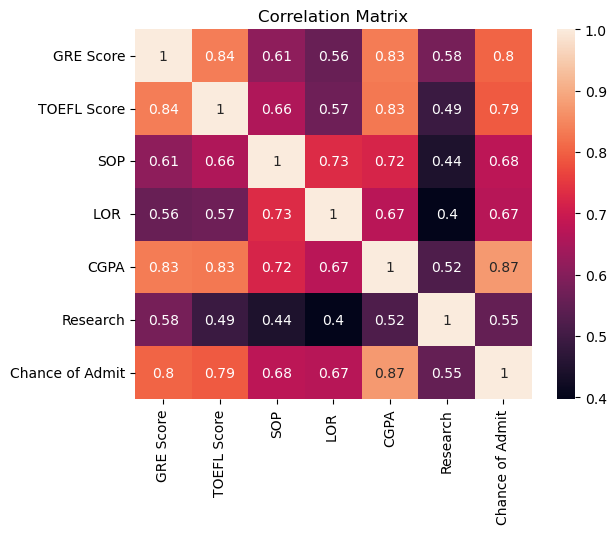

In [4]:
sns.heatmap(GAD.corr(numeric_only=True), annot=True)
plt.title('Correlation Matrix')
plt.show()

Now as we said, we want to predict the **chance of admission** with the help of the other columns, so we create a dataframe **X** with all the other variables except `Chance of Admit`.

In [5]:
# We assign the variable Y to the chance of admission
y = GAD[['Chance of Admit']]

# We create the dataframe X
X = GAD.drop('Chance of Admit', axis = 1)

X.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
Serial No.,,,,,,,
1,337,118,GOOD,4.5,4.5,9.65,1
2,324,107,GOOD,4.0,4.5,8.87,1
3,316,104,AVERAGE,3.0,3.5,8.00,1
4,322,110,AVERAGE,3.5,2.5,8.67,1
5,314,103,FAIR,2.0,3.0,8.21,0


In [6]:
X.dtypes

GRE Score              int64
TOEFL Score            int64
University Rating     object
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
dtype: object

Now we need to handle the `University Ranking`.
We will do both, one-hot and label encoding.

For *label encoding*, we can use Sklearn's `LabelEncoder()` function.


In [7]:
# Creating X_lab for comparison later with X_hot
X_label = X.copy()

# We will use LabelEncoder
label_encoder = LabelEncoder()

# Applying the LabelEncoder to the 'University Ranking' column
X_label['University Rating'] = label_encoder.fit_transform(X_label['University Rating'])

In [8]:
display(X_label.head())
display(X_label['University Rating'].unique())

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
Serial No.,,,,,,,
1,337,118,3,4.5,4.5,9.65,1
2,324,107,3,4.0,4.5,8.87,1
3,316,104,0,3.0,3.5,8.00,1
4,322,110,0,3.5,2.5,8.67,1
5,314,103,2,2.0,3.0,8.21,0


array([3, 0, 2, 1, 4])

In [9]:
label_encoder.classes_ # Here we can see that the 0 corresponds to Average, 1 is excellent, 2 Fair, 3 Good and 4 Poor

array(['AVERAGE', 'EXCELLENT', 'FAIR', 'GOOD', 'POOR'], dtype=object)

For *one-hot* encoding we use pandas `get_dummy` function.

In [10]:
# 1-hot encoding

# We create a DF with Dummy variables
dummies = pd.get_dummies(GAD["University Rating"])
X_hot = pd.concat([X, dummies], axis = 1) # We put together the X with the dummy columns we created

# We drop the Rating column
del X_hot["University Rating"]

# Have a look at what dummies actually looks like
display(dummies)
display(X_hot.head())

,AVERAGE,EXCELLENT,FAIR,GOOD,POOR
Serial No.,,,,,
1,False,False,False,True,False
2,False,False,False,True,False
3,True,False,False,False,False
4,True,False,False,False,False
5,False,False,True,False,False
...,...,...,...,...,...
396,True,False,False,False,False
397,True,False,False,False,False
398,False,False,False,True,False


,GRE Score,TOEFL Score,SOP,LOR,CGPA,Research,AVERAGE,EXCELLENT,FAIR,GOOD,POOR
Serial No.,,,,,,,,,,,
1,337,118,4.5,4.5,9.65,1,False,False,False,True,False
2,324,107,4.0,4.5,8.87,1,False,False,False,True,False
3,316,104,3.0,3.5,8.00,1,True,False,False,False,False
4,322,110,3.5,2.5,8.67,1,True,False,False,False,False
5,314,103,2.0,3.0,8.21,0,False,False,True,False,False


We will now build two models, one for 1-hot encoding and one for label encoding.


Let's start with *label encoding*:

In [11]:
# Split Dataset
X_train_lab, X_test_lab, y_train_lab, y_test_lab = train_test_split(X_label, y, test_size=0.2, random_state=0, shuffle=True) # Spliting training and testing

# Fit the model
model_lab = LinearRegression()
model_lab.fit(X_train_lab, y_train_lab) # Fit the model on the training data

# Calculate R2
lab_r2 = round(model_lab.score(X_train_lab, y_train_lab), 4)
print("R^2 of train set using label encoding: ", lab_r2 )

# Calculate Scores on Test-Set
label_predictions = model_lab.predict(X_test_lab)
lab_mae = mean_absolute_error(y_test_lab, label_predictions)
lab_mse = mean_squared_error(y_test_lab, label_predictions)
lab_r2_test = r2_score(y_test_lab, label_predictions)

print("MAE LAB %.2f" % lab_mae)
print("MSE LAB %.2f" % lab_mse)
print("R^2 score LAB %.4f" % lab_r2_test)


R^2 of train set using label encoding:  0.8165
MAE LAB 0.05
MSE LAB 0.00
R^2 score LAB 0.7355


And now with *1-hot*:

In [12]:
# Split Dataset
X_train_hot, X_test_hot, y_train_hot, y_test_hot = train_test_split(X_hot, y, test_size=0.2, random_state=0, shuffle=True)

# Fit the model
model_hot = LinearRegression()
model_hot.fit(X_train_hot, y_train_hot)

# Calculate R2
hot_r2 = round(model_hot.score(X_train_hot, y_train_hot), 4)
print("R^2 Train Score using 1-hot encoding : ", hot_r2 )

# Calculate Scores on Test-Set
hot_predictions = model_hot.predict(X_test_hot)
hot_mae = mean_absolute_error(y_test_hot, hot_predictions)
hot_mse = mean_squared_error(y_test_hot, hot_predictions)
hot_r2_test = r2_score(y_test_hot, hot_predictions)


print("MAE HOT %.2f" % hot_mae)
print("MSE HOT %.2f" % hot_mse)
print("R^2 score HOT %.4f" % hot_r2_test)


R^2 Train Score using 1-hot encoding :  0.8182
MAE HOT 0.05
MSE HOT 0.00
R^2 score HOT 0.7403


In [13]:
print("The 1-hot encoding method yields an R^2 {}% higher than using label encoding for the train set.".format(round((hot_r2/lab_r2 -1)*100, 3)))

The 1-hot encoding method yields an R^2 0.208% higher than using label encoding for the train set.


In [14]:
print("The 1-hot encoding method yields an R^2 {}% higher than using label encoding for the test set.".format(round((hot_r2_test/lab_r2_test -1)*100, 3)))

The 1-hot encoding method yields an R^2 0.65% higher than using label encoding for the test set.


Have a look at how the **intercepts** and the **coefficient**s change for each method:

In [15]:
print("Intercept: ", model_hot.intercept_[0])
print("Intercept: ", model_lab.intercept_[0])

Intercept:  -1.284738524004085
Intercept:  -1.3605812826822135


In [16]:
weights_hot = model_hot.coef_.flatten()
weights_lab = model_lab.coef_.flatten()

print("Features coefficients for HOT (weigths): ", model_hot.coef_)
print("Features coefficients for LAB (weigths): ", model_lab.coef_)

Features coefficients for HOT (weigths):  [[ 0.0020506   0.00202487 -0.00418539  0.02129711  0.12447107  0.02416713
  -0.0036891   0.01520818 -0.01014306  0.00121785 -0.00259387]]
Features coefficients for LAB (weigths):  [[ 0.0021295   0.00213468  0.00026054 -0.00262146  0.02259374  0.1276427
   0.02445849]]


# POLYNOMIAL LINEAR REGRESSION

We will now have a look at another model. We are going to use `Advertisement` data we used last week. The task is to figure out how different means of advertisement influence the amount of sales of a product.

In [17]:
ad_df = pd.read_csv('https://media.githubusercontent.com/media/michalis0/Business-Intelligence-and-Analytics/master/data/Advertising.csv', index_col = "id")
ad_df.head()

,TV,Radio,Newspaper,Sales
id,,,,
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


As we did before, we start by fixing our variables Y and X. In this case our dependent variable is going to be `Sales`and the independent variable will be the different means of advertisment (`TV`, `Radio`and `Newspaper`).

In [18]:
y = ad_df["Sales"]
X = ad_df.drop("Sales", axis = 1)

In [19]:
# First let's go for a linear multivariate regression
# You should know the drill by now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# 3. Performance metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Test scores: ")
print("MAE %.2f" % mae)
print("MSE %.2f" % mse)
print("R^2 %.2f" % r2)

print("Train metrics")
print("params: ", model.coef_)
print("constant: ", model.intercept_)
print("R^2 score: ", model.score(X, y))

Test scores: 
MAE 1.36
MSE 4.40
R^2 0.86
Train metrics
params:  [ 0.04458402  0.19649703 -0.00278146]
constant:  2.99489303049533
R^2 score:  0.8964076641629948


Using polynomial regression enables you to predict the best fit line that follows the pattern (curve) of the data. It tends to increase the performance of the model. The function `PolynomialFeatures` generates a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree.

For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2]. Let's try it on our model.

In [20]:
# Polynomial regression
poly = PolynomialFeatures(2) # We want degree-2 polynomial features
X = np.array(ad_df[["TV", "Radio"]]) # Theses are the two features we want to use. We will have in the array : 1 , TV , Radio , TV^2 , TV * Radio , Radio^2
y = np.array(ad_df["Sales"])
X_poly = poly.fit_transform(X) # Normalizing

In [21]:
X_poly

array([[1.000000e+00, 2.301000e+02, 3.780000e+01, 5.294601e+04,
        8.697780e+03, 1.428840e+03],
       [1.000000e+00, 4.450000e+01, 3.930000e+01, 1.980250e+03,
        1.748850e+03, 1.544490e+03],
       [1.000000e+00, 1.720000e+01, 4.590000e+01, 2.958400e+02,
        7.894800e+02, 2.106810e+03],
       ...,
       [1.000000e+00, 1.770000e+02, 9.300000e+00, 3.132900e+04,
        1.646100e+03, 8.649000e+01],
       [1.000000e+00, 2.836000e+02, 4.200000e+01, 8.042896e+04,
        1.191120e+04, 1.764000e+03],
       [1.000000e+00, 2.321000e+02, 8.600000e+00, 5.387041e+04,
        1.996060e+03, 7.396000e+01]])

In [22]:
LR = LinearRegression(fit_intercept=False) # We don't need fit intercept since polynomial features function add a column of ones to the data
LR.fit(X_poly, y) # We make a linear regression of the model which is in the format b0 + b1 TV + b2 Radio + b3 TV^2 + b4 TV*Radio + b5 Radio^2
print("params: ", LR.coef_)
print("R^2 score: ", LR.score(X_poly, y))

params:  [ 5.19444187e+00  5.09930683e-02  2.65400299e-02 -1.09816273e-04
  1.07462080e-03  1.86076136e-04]
R^2 score:  0.986039101078374


## OVERFITTING
Beware, adding too many features may cause **overfitting**.
Remember that overfitting is is the tendency of data mining procedures to tailor models to the training data, at the expense of generalization to previously unseen data points. We want to avoid this case.

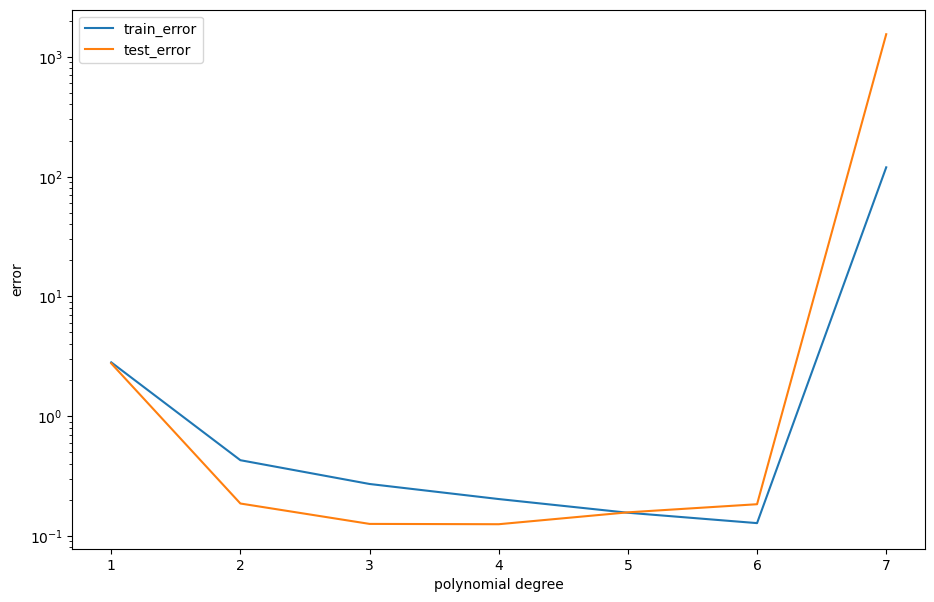

In [24]:
train_err = []
test_err = []
for f in range(1,8):
    poly = PolynomialFeatures(f)
    X_poly = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=12)
    LR = LinearRegression(fit_intercept=False)
    LR.fit(X_train, y_train)
    train_err.append(mean_squared_error(y_train, LR.predict(X_train)))
    test_err.append(mean_squared_error(y_test, LR.predict(X_test)))


fig = plt.figure(figsize=(11,7))
plt.plot(range(1,8), train_err, label="train_error")
plt.plot(range(1,8), test_err, label="test_error")
plt.legend(fontsize=10)
plt.xlabel("polynomial degree")
plt.yscale('log') # Putting in log scale the y axis because the error skyrockets whrn having 7 degrees
plt.ylabel("error")
plt.show()


In [25]:
from sklearn.model_selection import KFold


y = ad_df["Sales"]
X = ad_df.drop("Sales", axis = 1)

kf = KFold(n_splits = 10, random_state = None) # this means we try 10 different folds, meaning a test size of 10%
model = LinearRegression()

mae_cumm = []
mse_cumm = []
r2_cumm = []

for train_index, test_index in kf.split(X): # We make for each of the 10 folds the calculations

  X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  model.fit(X_train, y_train)
  predictions = model.predict(X_test)


  mae = mean_absolute_error(y_test, predictions)
  mse = mean_squared_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)

  mae_cumm.append(mae)
  mse_cumm.append(mse)
  r2_cumm.append(r2)


mean_mae = sum(mae_cumm)/len(mae_cumm) # looking at the averages of the 10 folds
mean_mse = sum(mse_cumm)/len(mse_cumm)
mean_r2 = sum(r2_cumm)/len(r2_cumm)

print("The average mean absolute error of all our folds was: ",round(mean_mae, 3))
print("The average mean squared error of all our folds was: ", round(mean_mse, 3))
print("The average R^2 score of all our folds was: ", round(mean_r2, 3))


The average mean absolute error of all our folds was:  1.302
The average mean squared error of all our folds was:  3.06
The average R^2 score of all our folds was:  0.885


And for higher order polynomial regression:

[2.770302360080497, 0.3625454931923563, 0.2108067440804634, 0.13884563579865558, 0.07067893128003724, 0.06947940270837547]
[3.0599676181185096, 0.42985425650836107, 0.3190220306321635, 0.2658030595692497, 2.433287070065804, 87.34667316670459]


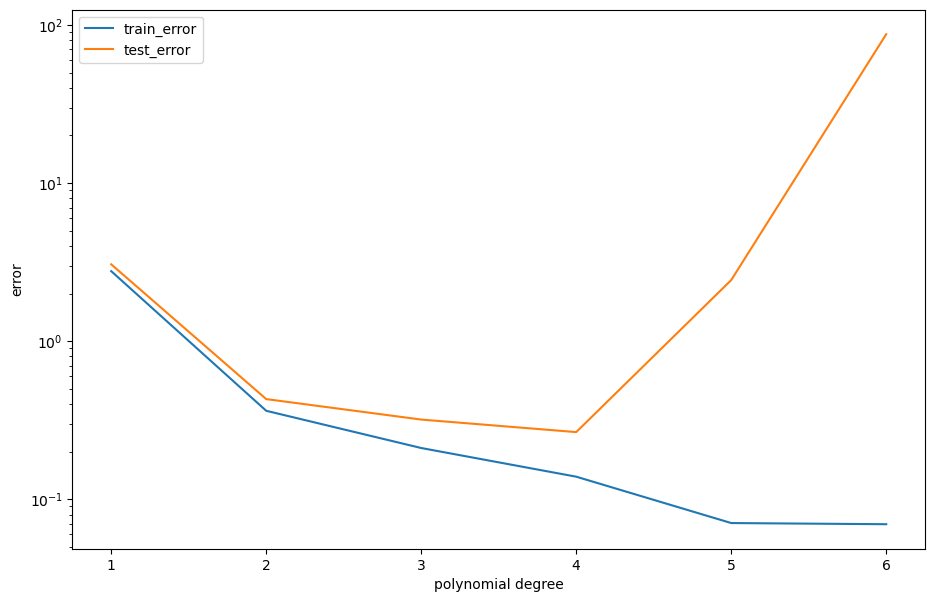

In [26]:
train_err = []
test_err = []

y = ad_df["Sales"]
X = ad_df.drop("Sales", axis = 1)

kf = KFold(n_splits = 10, random_state = None) # We make 10 folds
model = LinearRegression(fit_intercept = False)

for f in range(1,7): # We try 7 different ploynomial degrees
  train = []
  test = []
  for train_index, test_index in kf.split(X): # We make for each fold
    poly = PolynomialFeatures(f)
    X_poly = poly.fit_transform(X)
    X_train, X_test = X_poly[train_index,:], X_poly[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    train.append(mean_squared_error(y_train, model.predict(X_train)))
    test.append(mean_squared_error(y_test, model.predict(X_test)))

  train_err.append(statistics.mean(train))
  test_err.append(statistics.mean(test))

fig=plt.figure(figsize=(11,7))
plt.plot(range(1,7), train_err, label="train_error")
plt.plot(range(1,7), test_err, label="test_error")
plt.legend(fontsize=10)
plt.xlabel("polynomial degree")
plt.yscale('log') # Log scale because the error increases a lot and we don't see as much
plt.ylabel("error")
print(train_err)
print(test_err)